In [2]:
%matplotlib inline

/Users/yaolun/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
import astropy.constants as const

c = const.c.cgs.value

## Some functions

In [4]:
def CircularAperture(x, y, r, pix=10000.):
    
    grid_x, grid_y = np.meshgrid(np.linspace(0,pix-1,pix), np.linspace(0,pix-1,pix))
    grid_x = grid_x - (pix-1)/2.
    grid_y = grid_y - (pix-1)/2.
    grid_dist = ((grid_x-x)**2+(grid_y-y)**2)**0.5
    aperture = np.where(grid_dist <= r, np.full((pix, pix), 1, dtype=int), 0)
    
    return aperture

In [5]:
def Total_MaskedAperture(aperture, mask):
    
    aperture_masked = np.where(mask != 0, aperture, 0)
    
    return aperture_masked, np.sum(aperture_masked)

In [6]:
def Mask(x, y, radius, pix=10000.):
    
    init_arr = np.full((pix, pix), 1, dtype=int)
    grid_x, grid_y = np.meshgrid(np.linspace(0,pix-1,pix), np.linspace(0,pix-1,pix))
    
    dist_x = grid_x - (pix-1)/2. - x
    dist_y = grid_y - (pix-1)/2. - y
    
    aper_trim = np.where((dist_x**2+dist_y**2)**0.5 <= radius, init_arr, 0)
    
    return aper_trim

## SPIRE beam profiles

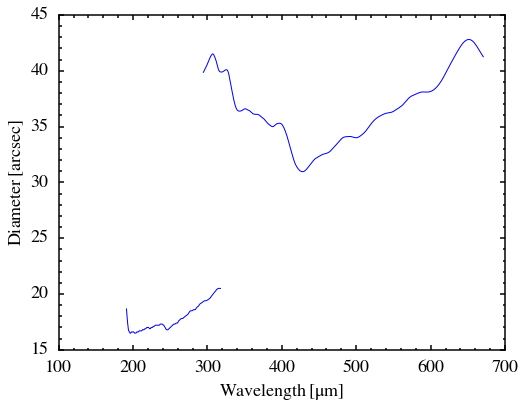

In [66]:
# read in the SSW beam profile
wl_ssw_beam, diam_ssw_beam = np.genfromtxt('/Users/yaolun/test/SSW_beam_profile.txt').T

# read in the SLW beam profile
wl_slw_beam, diam_slw_beam = np.genfromtxt('/Users/yaolun/test/SLW_beam_profile.txt').T

# plot beam profiles
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(wl_ssw_beam, diam_ssw_beam, 'b-')
ax.plot(wl_slw_beam, diam_slw_beam, 'b-')
# ax.axhline(31.8, color='k', linestyle='--')

ax.set_xlim([100, 700])
ax.set_xlabel(r'$\rm{Wavelength\,[\mu m]}$', fontsize=18)
ax.set_ylabel(r'$\rm{Diameter\,[arcsec]}$', fontsize=18)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)

fig.savefig('/Users/yaolun/test/spire_beam.pdf', format='pdf', dpi=300, bbox_inches='tight')

#### The full calculation of the convolution of pixel and ciricular sperture is only matter for a tiny region of wavelength

In [8]:
from scipy.interpolate import interp1d
f_ssw = interp1d(wl_ssw_beam, diam_ssw_beam)
f_slw = interp1d(wl_slw_beam, diam_slw_beam)
print f_ssw(250), f_slw(350), f_slw(500)
source_size = 31.0
print (f_ssw(250)**2+source_size**2)**0.5, (f_slw(350)**2+source_size**2)**0.5, (f_slw(500)**2+source_size**2)**0.5

17.001053 36.5897227218 34.000117
35.3558453881 47.9563114601 46.0109547392


# SPIRE FITS

In [13]:
hdu = fits.open('/Users/yaolun/bhr71/calibration_testing/HSA/bhr71_spire_extended_apod.fits')

In [48]:
for i in range(2,56):
    print i, hdu[i].header['CHNLNAME']

2 SLWA1
3 SLWA2
4 SLWA3
5 SLWB1
6 SLWB2
7 SLWB3
8 SLWB4
9 SLWC1
10 SLWC2
11 SLWC3
12 SLWC4
13 SLWC5
14 SLWD1
15 SLWD2
16 SLWD3
17 SLWD4
18 SLWE1
19 SLWE2
20 SLWE3
21 SSWA1
22 SSWA2
23 SSWA3
24 SSWA4
25 SSWB1
26 SSWB2
27 SSWB3
28 SSWB4
29 SSWB5
30 SSWC1
31 SSWC2
32 SSWC3
33 SSWC4
34 SSWC5
35 SSWC6
36 SSWD1
37 SSWD2
38 SSWD3
39 SSWD4
40 SSWD6
41 SSWD7
42 SSWE1
43 SSWE2
44 SSWE3
45 SSWE4
46 SSWE5
47 SSWE6
48 SSWF1
49 SSWF2
50 SSWF3
51 SSWF5
52 SSWG1
53 SSWG2
54 SSWG3
55 SSWG4


### Flux unit: W m-2 Hz-1 sr-1

## Weights for SSW

In [58]:
%%time
# do 200" x 200"
pix = 3000.
factor = pix/250.
aper_rad = 200
weight_ssw = np.empty((len(range(21,56)), len(diam_ssw_beam)))
aperture = CircularAperture(0, 0, aper_rad*factor, pix=pix)
ideal = (diam_ssw_beam*factor/2.)**2*np.pi

a_ssw = np.full((pix, pix), 0)

# center of SSW module
cen_ra = hdu[39].header['RA']
cen_dec = hdu[39].header['DEC']

# SSW
s = 0
for i in range(21,56):
    ra = (hdu[i].header['RA']-cen_ra)*np.cos(np.radians(cen_dec))*3600.
    dec = (hdu[i].header['DEC']-cen_dec) * 3600.
    
    # check if the pixel has any overlap with the aperture to save some computing time
    if (ra**2+dec**2)**0.5 > aper_rad+(max(diam_ssw_beam)/2.):
        weight_ssw[i-9,:].fill(0)
        continue
        
#     for iw in range(len(diam_ssw_beam)):
    for iw in range(0,1):
        masked_arr, arr_sum = Total_MaskedAperture(aperture,
                                    Mask(ra*factor, dec*factor, diam_ssw_beam[iw]*factor/2., pix=pix))
        if (arr_sum/ideal[iw]) >= 0.99:
            weight_ssw[i-21,iw] = 1
        else:
            weight_ssw[i-21,iw] = arr_sum/ideal[iw]
            s += 1
    a_ssw = a_ssw + masked_arr

CPU times: user 9.76 s, sys: 6.79 s, total: 16.5 s
Wall time: 16.6 s


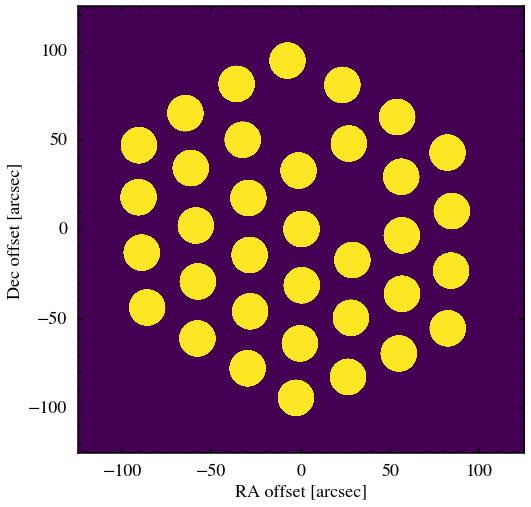

In [59]:
aperture = CircularAperture(0, 0, 15.9*factor, pix=pix)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.imshow(a_ssw, cmap='viridis', extent=[-125,125,-125,125])

[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)
ax.set_xlabel('RA offset [arcsec]', fontsize=18)
ax.set_ylabel('Dec offset [arcsec]', fontsize=18)

fig.savefig('/Users/yaolun/bhr71/calibration_testing/spire_ssw.pdf', format='pdf', dpo=300, bbox_inches='tight')

In [ ]:
# create empty arrays and apply the weighting
wl_ssw_wsum = c/1e5/hdu[18].data.field(0)
flux_ssw_wsum = np.zeros_like(wl_ssw_wsum)

for iw in range(len(wl_ssw_wsum)):
    for i in range(9,26):
        flux_dum = hdu[i].data.field(1)
        flux_ssw_wsum[iw] += flux_dum[iw] * weight_ssw[i-9,iw]

# sort the spectrum with the increase of wavelength
sorter = np.argsort(wl_ssw_wsum)
wl_ssw_wsum = wl_ssw_wsum[sorter]
flux_ssw_wsum = flux_ssw_wsum[sorter]

# trim the spectrum like SPIRE-1D spectra in CDF archive
flux_ssw_wsum = flux_ssw_wsum[(wl_ssw_wsum >= 195.) & (wl_ssw_wsum < 310.)]
wl_ssw_wsum = wl_ssw_wsum[(wl_ssw_wsum >= 195.) & (wl_ssw_wsum < 310.)]

# write the summed spectrum into ASCII file
foo = open('/Users/yaolun/bhr71/calibration_testing/bhr71_ssw_tophat_weighted_sum.txt','w')
for wave in wl_ssw_wsum:
    foo.write('{} \t {}\n'.format(wave, flux_ssw_wsum[wl_ssw_wsum == wave][0]))
foo.close()

# save the SSW weight array
np.save('/Users/yaolun/bhr71/calibration_testing/bhr71_ssw_tophat_weight', weight_ssw)

## Weights for SLW

In [61]:
%%time
# do 200" x 200"
pix = 3000.
factor = pix/250.
aper_rad = 200
weight_slw = np.empty((len(range(2,21)), len(diam_slw_beam)))
aperture = CircularAperture(0, 0, aper_rad*factor, pix=pix)
ideal = (diam_slw_beam*factor/2.)**2*np.pi

a_slw = np.full((pix, pix), 0)

# center of SLW module
cen_ra = hdu[11].header['RA']
cen_dec = hdu[11].header['DEC']

# SSW
for i in range(2,21):
    ra = (hdu[i].header['RA']-cen_ra)*np.cos(np.radians(cen_dec))*3600.
    dec = (hdu[i].header['DEC']-cen_dec) * 3600.
    
    # check if the pixel has any overlap with the aperture to save some computing time
    if (ra**2+dec**2)**0.5 > aper_rad+max(diam_slw_beam)/2.:
        weight_slw[i-2,:].fill(0)
        continue

#     for iw in range(len(diam_slw_beam)):
    for iw in range(1):
        masked_arr, arr_sum = Total_MaskedAperture(aperture,
                                    Mask(ra*factor, dec*factor, diam_slw_beam[iw]*factor/2., pix=pix))
        if (arr_sum/ideal[iw]) >= 0.99:
            weight_slw[i-2,iw] = 1
        else:
            weight_slw[i-2,iw] = arr_sum/ideal[iw]
    a_slw = a_slw + masked_arr

CPU times: user 5.37 s, sys: 3.71 s, total: 9.08 s
Wall time: 9.13 s


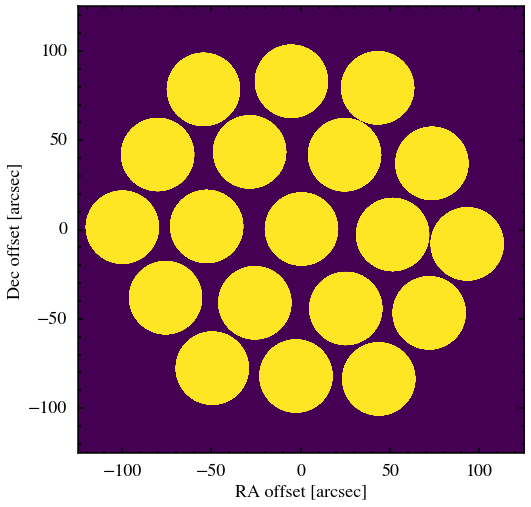

In [62]:
aperture = CircularAperture(0, 0, 15.9*factor, pix=pix)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.imshow(a_slw, cmap='viridis', extent=[-125,125,-125,125])

[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)
ax.set_xlabel('RA offset [arcsec]', fontsize=18)
ax.set_ylabel('Dec offset [arcsec]', fontsize=18)

fig.savefig('/Users/yaolun/bhr71/calibration_testing/spire_slw.pdf', format='pdf', dpo=300, bbox_inches='tight')

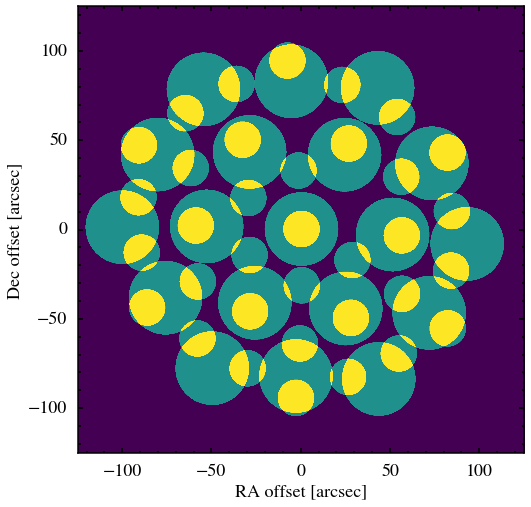

In [63]:
aperture = CircularAperture(0, 0, 15.9*factor, pix=pix)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.imshow(a_slw+a_ssw, cmap='viridis', extent=[-125,125,-125,125])

[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)
ax.set_xlabel('RA offset [arcsec]', fontsize=18)
ax.set_ylabel('Dec offset [arcsec]', fontsize=18)

fig.savefig('/Users/yaolun/bhr71/calibration_testing/spire_slw_ssw.pdf', format='pdf', dpo=300, bbox_inches='tight')

In [ ]:
weight_slw_copy = weight_slw

In [15]:
# create empty arrays and apply the weighting
wl_slw_wsum = c/1e5/hdu[5].data.field(0)
flux_slw_wsum = np.zeros_like(wl_slw_wsum)

for iw in range(len(wl_slw_wsum)):
    for i in range(2,9):
        flux_dum = hdu[i].data.field(1)
        flux_slw_wsum[iw] += flux_dum[iw] * weight_slw[i-2,iw]
        
# sort the spectrum with the increase of wavelength
sorter = np.argsort(wl_slw_wsum)
wl_slw_wsum = wl_slw_wsum[sorter]
flux_slw_wsum = flux_slw_wsum[sorter]

# trim the spectrum like SPIRE-1D spectra in CDF archive
flux_slw_wsum = flux_slw_wsum[wl_slw_wsum >= 310.]
wl_slw_wsum = wl_slw_wsum[wl_slw_wsum >= 310.]

# write the summed spectrum into ASCII file
foo = open('/Users/yaolun/bhr71/calibration_testing/bhr71_slw_tophat_weighted_sum.txt','w')
foo.write('{} \t {}\n'.format('Wavelength(um)', 'Flux(Jy)'))
for wave in wl_slw_wsum:
    foo.write('{} \t {}\n'.format(wave, flux_slw_wsum[wl_slw_wsum == wave][0]))
foo.close()
# save the SLW weight array
np.save('/Users/yaolun/bhr71/calibration_testing/bhr71_slw_tophat_weight', weight_slw)

In [ ]:
plt.imshow(a+aperture, cmap='viridis')

In [ ]:
# SLW
slw_area = 0
slw_cen_area = Gaussian_anywhere(grid, 0, 0, avg_slw)
for j in range(2,10):
    ra_dum = (hdu[j].header['RA']-cen_ra)*np.cos(np.radians(cen_dec))*3600.
    dec_dum = (hdu[j].header['DEC']-cen_dec) * 3600.
    slw_area += Gaussian_anywhere(grid, ra_dum, dec_dum, avg_slw)

print ssw_cen_area, slw_cen_area
print ssw_area, slw_area, ssw_area/slw_area